# Figure 4: Perturbation Recovery

This notebook analyzes how long it takes models to recover from perturbations of varying lengths applied at different epochs. Recovery is defined as returning to within 1% of baseline test loss.

## Import Libraries

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import numpy as np

## Load and Prepare Baseline Data

In [2]:
# Load baseline results
baseline_csv = Path('../../Data/clip_results/baseline_clip_results_seed1.csv')

if baseline_csv.exists():
    baseline_df = pd.read_csv(baseline_csv)
    print(f"Baseline data loaded: {len(baseline_df)} epochs")
else:
    raise FileNotFoundError("Baseline data not found")

# Trim at minimum test loss (early stopping point)
baseline_min_test_loss_idx = baseline_df['test_loss'].idxmin()
baseline_df = baseline_df.loc[:baseline_min_test_loss_idx].copy()

print(f"Data trimmed to {len(baseline_df)} epochs (up to minimum test loss)")
print(baseline_df.head())

Baseline data loaded: 118 epochs
Data trimmed to 98 epochs (up to minimum test loss)
   epoch  train_loss   test_loss  behavioral_rsa_rho  behavioral_rsa_p_value
0      1  143.198375  114.267337            0.455443            7.497325e-59
1      2   99.003030   91.310430            0.422459            4.797240e-50
2      3   88.155927   84.871568            0.421268            9.572966e-50
3      4   82.863315   80.375895            0.425018            1.076738e-50
4      5   78.583811   76.447118            0.440511            9.591843e-55


## Load Perturbation Length Experiment Data

In [3]:
# Path to perturbation length experiments
perturb_length_base_dir = Path('../../Data/clip_results/perturb_length_experiments_baselineseed1_perturbseed0')

# List all training run directories
run_dirs = sorted([d for d in perturb_length_base_dir.iterdir() 
                  if d.is_dir() and d.name.startswith('random_target')])

print(f"Found {len(run_dirs)} perturbation runs")

Found 136 perturbation runs


## Parse Run Metadata and Load Results

In [4]:
# Load all perturbation length experiment results
all_perturb_length_dfs = {}

for run_dir in run_dirs:
    # Check for metrics.csv or training_res.csv
    csv_file = None
    if (run_dir / 'metrics.csv').exists():
        csv_file = run_dir / 'metrics.csv'
    elif (run_dir / 'training_res.csv').exists():
        csv_file = run_dir / 'training_res.csv'
    
    if csv_file:
        df = pd.read_csv(csv_file)
        all_perturb_length_dfs[run_dir.name] = df

print(f"Loaded {len(all_perturb_length_dfs)} run results")

# Filter out epochs after early stopping (minimum test loss)
all_perturb_length_data = {}

for run_name, df in all_perturb_length_dfs.items():
    if len(df) == 0:
        all_perturb_length_data[run_name] = df
        continue
    
    # Trim at minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()
    filtered_df = df.loc[:min_test_loss_idx].copy()
    all_perturb_length_data[run_name] = filtered_df

print(f"Filtered data to early stopping points")

Loaded 136 run results
Filtered data to early stopping points


## Extract Run Metadata (Start Epoch and Length)

In [5]:
# Parse run names to extract start epoch and perturbation length
# Format: "random_target_e{epoch}_l{length}"
run_metadata = []

for run_name, df in all_perturb_length_dfs.items():
    if 'random_target_e' in run_name:
        parts = run_name.split('_')
        start_epoch = None
        length = None
        
        for part in parts:
            if part.startswith('e') and part[1:].isdigit():
                start_epoch = int(part[1:])
            elif part.startswith('l') and part[1:].isdigit():
                length = int(part[1:])
        
        if start_epoch is not None and length is not None:
            run_metadata.append({
                'run_name': run_name,
                'start_epoch': start_epoch,
                'length': length,
                'df': df
            })

print(f"Parsed {len(run_metadata)} runs with metadata")
print(f"\nExample runs:")
for i in range(min(5, len(run_metadata))):
    r = run_metadata[i]
    print(f"  {r['run_name']}: start_epoch={r['start_epoch']}, length={r['length']}")

Parsed 136 runs with metadata

Example runs:
  random_target_e10_l10: start_epoch=10, length=10
  random_target_e10_l2: start_epoch=10, length=2
  random_target_e10_l20: start_epoch=10, length=20
  random_target_e10_l30: start_epoch=10, length=30
  random_target_e10_l40: start_epoch=10, length=40


## Calculate Recovery Times

In [6]:
# Calculate recovery times for test loss within 1% of baseline
recovery_data = []

for run_info in run_metadata:
    run_name = run_info['run_name']
    df = run_info['df']
    start_epoch = run_info['start_epoch']
    length = run_info['length']
    
    # Calculate when perturbation ends
    perturbation_end = start_epoch + length - 1
    
    # Sort by epoch
    df_sorted = df.sort_values('epoch')
    
    # Find first epoch AFTER perturbation ends where test_loss is within 1% of baseline
    recovery_epoch = None
    
    for _, row in df_sorted.iterrows():
        current_epoch = int(row['epoch'])
        
        # Only check epochs after perturbation has ended
        if current_epoch <= perturbation_end:
            continue
        
        # Get baseline loss at the same epoch
        baseline_at_same_epoch = baseline_df[baseline_df['epoch'] == current_epoch]
        
        if len(baseline_at_same_epoch) > 0:
            baseline_loss = baseline_at_same_epoch.iloc[0]['test_loss']
            target_loss = baseline_loss * 1.01  # Within 1% of baseline
            if row['test_loss'] <= target_loss:
                recovery_epoch = current_epoch
                break
        else:
            # Compare to minimum baseline test loss
            baseline_loss = baseline_df['test_loss'].min()
            target_loss = baseline_loss * 1.01
            if row['test_loss'] <= target_loss:
                recovery_epoch = current_epoch
                break
    
    if recovery_epoch is not None:
        epochs_to_recovery = recovery_epoch - perturbation_end
        recovery_data.append({
            'run_name': run_name,
            'start_epoch': start_epoch,
            'length': length,
            'perturbation_end': perturbation_end,
            'recovery_epoch': recovery_epoch,
            'epochs_to_recovery': epochs_to_recovery,
            'label': f'E{start_epoch}_L{length}',
            'recovered': True
        })
    else:
        recovery_data.append({
            'run_name': run_name,
            'start_epoch': start_epoch,
            'length': length,
            'perturbation_end': perturbation_end,
            'recovery_epoch': None,
            'epochs_to_recovery': None,
            'label': f'E{start_epoch}_L{length}',
            'recovered': False
        })

# Convert to DataFrame
recovery_df = pd.DataFrame(recovery_data)
recovery_df = recovery_df.sort_values(['start_epoch', 'length'])

print(f"\nRecovery analysis complete")
print(f"Total runs: {len(recovery_df)}")
print(f"Recovered: {recovery_df['recovered'].sum()}")
print(f"Never recovered: {(~recovery_df['recovered']).sum()}")
print(recovery_df.head(10))


Recovery analysis complete
Total runs: 136
Recovered: 130
Never recovered: 6
                run_name  start_epoch  length  perturbation_end  \
26   random_target_e1_l2            1       2                 2   
30   random_target_e1_l5            1       5                 5   
25  random_target_e1_l10            1      10                10   
27  random_target_e1_l20            1      20                20   
28  random_target_e1_l30            1      30                30   
29  random_target_e1_l40            1      40                40   
31  random_target_e1_l50            1      50                50   
41   random_target_e2_l2            2       2                 3   
45   random_target_e2_l5            2       5                 6   
40  random_target_e2_l10            2      10                11   

    recovery_epoch  epochs_to_recovery   label  recovered  
26            43.0                41.0   E1_L2       True  
30            58.0                53.0   E1_L5       True  
25  

## Visualize Recovery Times

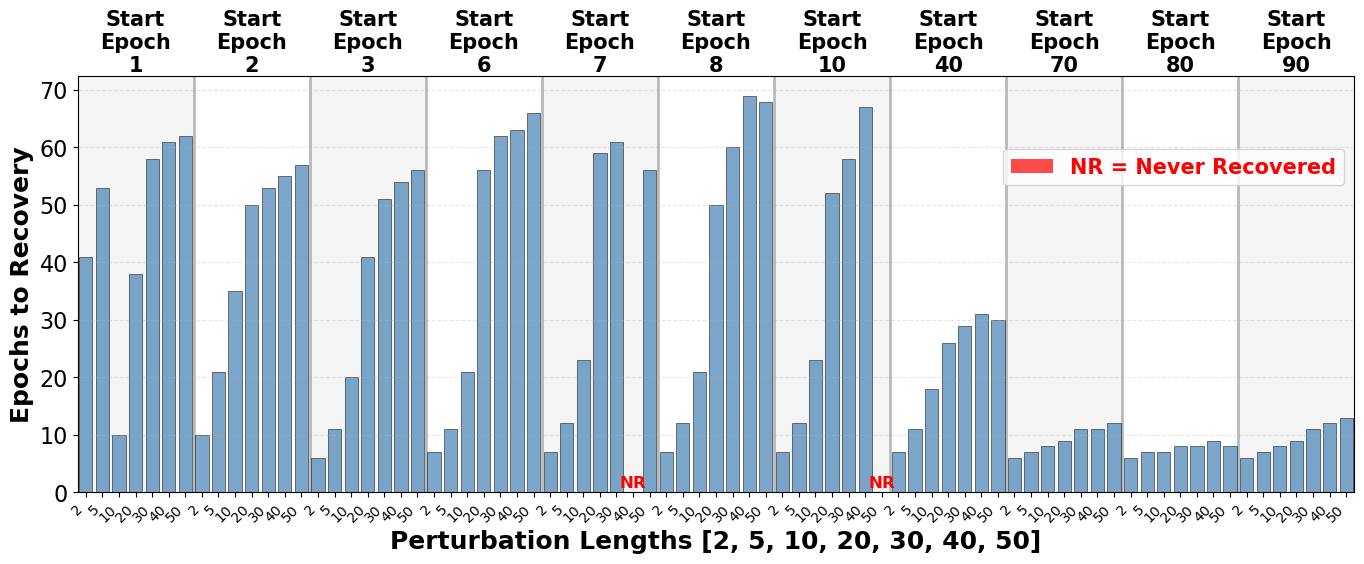


Recovery time statistics (epochs to within 1% of baseline):
  Filtered runs analyzed: 77
  Runs that recovered: 75
  Runs that never recovered: 2
  Mean recovery time: 29.2 epochs
  Standard deviation: 22.5 epochs
  Min recovery time: 6 epochs
  Max recovery time: 69 epochs

Never recovered runs:
  E7_L40
  E10_L50


In [7]:
# Filter to specific epochs shown in reference plot
epochs_to_include = [1, 2, 3, 6, 7, 8, 10, 40, 70, 80, 90]
recovery_df_filtered = recovery_df[recovery_df['start_epoch'].isin(epochs_to_include)].copy()

# Build plot data
x_positions = []
y_values = []
colors = []
x_labels = []
section_boundaries = []
section_centers = []
recovery_rows = []
curr_x = 0

unique_epochs = sorted(recovery_df_filtered['start_epoch'].unique())

for start_epoch in unique_epochs:
    section_data = recovery_df_filtered[recovery_df_filtered['start_epoch'] == start_epoch]
    section_start = curr_x
    
    for _, row in section_data.iterrows():
        x_positions.append(curr_x)
        # For never-recovered runs, set y to 0 so bar is invisible
        if row['recovered']:
            y_values.append(row['epochs_to_recovery'])
        else:
            y_values.append(0)
        colors.append('steelblue' if row['recovered'] else 'red')
        x_labels.append(f"{row['length']}")
        recovery_rows.append(row)
        curr_x += 1
    
    section_end = curr_x - 1
    section_boundaries.append((section_start - 0.5, section_end + 0.5))
    section_centers.append((section_start + section_end) / 2)

# Create figure
plt.figure(figsize=(14, 6))

bars = plt.bar(x_positions, y_values, alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)

# Add "NR" annotation for not recovered
for i, row in enumerate(recovery_rows):
    if not row['recovered']:
        plt.text(x_positions[i], 0.3, 'NR', ha='center', va='bottom', 
                 fontsize=12, fontweight='bold', color='red', zorder=10, clip_on=False)

plt.xlabel('Perturbation Lengths [2, 5, 10, 20, 30, 40, 50]', fontsize=18, fontweight='bold')
plt.ylabel('Epochs to Recovery', fontsize=18, fontweight='bold')
plt.yticks(fontsize=16)

# Add section labels
ymax = plt.ylim()[1]
label_y = ymax
for center, start_epoch in zip(section_centers, unique_epochs):
    plt.text(center, label_y, f"Start\nEpoch\n{start_epoch}", ha='center', va='bottom',
             fontsize=15, fontweight='bold', color='black', clip_on=False)

# Draw vertical lines between sections
for i in range(1, len(section_centers)):
    right = section_boundaries[i][0]
    plt.axvline(right, color='gray', linestyle='-', lw=2, alpha=0.5, zorder=0)

# Add background shading for alternating sections
for i, (section_start, section_end) in enumerate(section_boundaries):
    if i % 2 == 0:
        plt.axvspan(section_start, section_end, color='gray', alpha=0.08, zorder=0)

plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')

if x_positions:
    plt.xlim(left=min(x_positions) - 0.5, right=max(x_positions) + 0.5)

# Add legend
legend_elements = [Patch(facecolor='red', alpha=0.7, label='NR = Never Recovered')]
plt.legend(handles=legend_elements, fontsize=13, loc='upper right', bbox_to_anchor=(1, 0.85),
           labelcolor='red', prop={'weight': 'bold', 'size': 15})

plt.tight_layout(pad=2)
plt.show()

# Print summary statistics
recovered_runs = recovery_df_filtered[recovery_df_filtered['recovered'] == True]
never_recovered_runs = recovery_df_filtered[recovery_df_filtered['recovered'] == False]

print(f"\nRecovery time statistics (epochs to within 1% of baseline):")
print(f"  Filtered runs analyzed: {len(recovery_df_filtered)}")
print(f"  Runs that recovered: {len(recovered_runs)}")
print(f"  Runs that never recovered: {len(never_recovered_runs)}")

if len(recovered_runs) > 0:
    print(f"  Mean recovery time: {recovered_runs['epochs_to_recovery'].mean():.1f} epochs")
    print(f"  Standard deviation: {recovered_runs['epochs_to_recovery'].std():.1f} epochs")
    print(f"  Min recovery time: {recovered_runs['epochs_to_recovery'].min():.0f} epochs")
    print(f"  Max recovery time: {recovered_runs['epochs_to_recovery'].max():.0f} epochs")

if len(never_recovered_runs) > 0:
    print(f"\nNever recovered runs:")
    for _, row in never_recovered_runs.iterrows():
        print(f"  {row['label']}")